# Маркетинговая аналитика для Яндекс.Афиши

**Цель**. Помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

**Задачи**. Изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Данные для исследования:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Выручка измеряется в условных единицах — у.е.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'svg'

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

pd.set_option('chained_assignment', None)

In [2]:
try:
    visits = pd.read_csv('secret.csv')
    orders = pd.read_csv('secret.csv')
    costs = pd.read_csv('secret.csv')
except Exception as err:
    print('Ошибка:', err)

In [3]:
display(visits.head())
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
display(orders.head())
orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
display(costs.head())
costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Вывод

1. Неверные типы данных
2. Столбцы нужны привести к нижнему регистру и добавить андерскор

Данные прочитаны, приступим к предобработке данных

## Предобработка данных


Для начала в visits и orders исправим названия столбцов - приведем к нижнему регистру и добавим андерскор вместо пробела

In [6]:
visits.columns = [i.replace(" ", "_").lower() for i in visits.columns]
orders.columns = [i.replace(" ", "_").lower() for i in orders.columns]
print(visits.columns)
print(orders.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')


### Обработка пропусков

Проверим пропуски



In [7]:
display(pd.DataFrame(round((visits.isna().mean()*100), 2)).style.background_gradient('coolwarm'))
display(pd.DataFrame(round((orders.isna().mean()*100), 2)).style.background_gradient('coolwarm'))
display(pd.DataFrame(round((costs.isna().mean()*100), 2)).style.background_gradient('coolwarm'))

,0
device,0.000000
end_ts,0.000000
source_id,0.000000
start_ts,0.000000
uid,0.000000


,0
buy_ts,0.000000
revenue,0.000000
uid,0.000000


,0
source_id,0.000000
dt,0.000000
costs,0.000000


Пропусков нет, перейдем к замене типа данных

### Замена типа данных

In [8]:
print(visits.dtypes)
print()
print(orders.dtypes)
print()
print(costs.dtypes)

device       object
end_ts       object
source_id     int64
start_ts     object
uid          uint64
dtype: object

buy_ts      object
revenue    float64
uid         uint64
dtype: object

source_id      int64
dt            object
costs        float64
dtype: object


Проблемы у нас только с датами

In [9]:
for col in visits[['start_ts', 'end_ts']].columns:
    visits[col] = pd.to_datetime(visits[col], errors='coerce')

In [10]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], errors='coerce')
costs['dt'] = pd.to_datetime(costs['dt'], errors='coerce')

In [11]:
print(visits.dtypes)
print()
print(orders.dtypes)
print()
print(costs.dtypes)

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object


### Проверка на дубликаты

In [12]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


### Вывод

* С пропусками проблем не было.
* Заменили тип данных - даты привели к datetime
* Проверили датафреймы на наличие дубликатов

## Расчет метрик и их визуализация

### Продуктовые метрики

#### Рассчитаем Daily/Weekly/Monthly active users (DAU, WAU, MAU)

Для начала добавим новые столбцы с годом, месяцем, днем и полной датой

In [13]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


**DAU**

In [14]:
dau = (
    visits
        .groupby('session_date', as_index=False)
        .agg({'uid': 'nunique'})
        .rename(columns={'uid':'users'})
)

dau.head()

,session_date,users
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


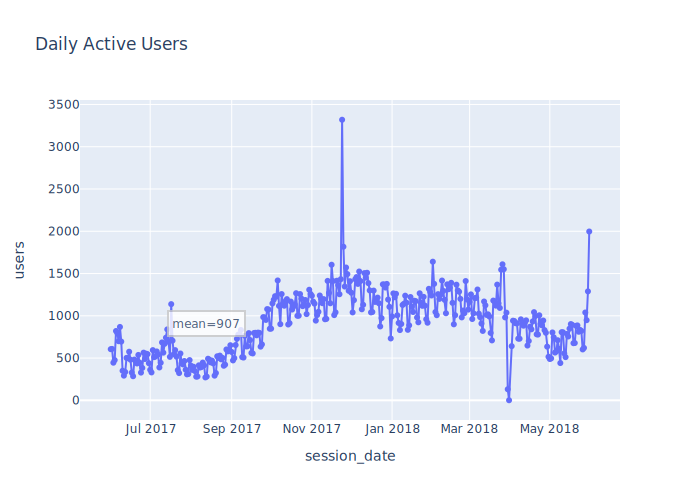

In [15]:
fig = px.scatter(dau, x='session_date', y='users',
                 title='Daily Active Users')

fig.update_traces(
    mode='lines+markers')

fig.add_annotation(x='2017-08-13', y=int(dau['users'].mean()),
        text=f"mean={int(dau['users'].mean())}",
        align="center",
        showarrow=False,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8)

fig.show()

**WAU**

In [16]:
wau = (
    visits
        .groupby('session_week', as_index=False)
        .agg({'uid': 'nunique'})
        .rename(columns={'uid':'users'})
)

wau.head()

,session_week,users
0,2017-06-01,4082
1,2017-06-08,3311
2,2017-06-15,2844
3,2017-06-22,3079
4,2017-06-29,3055


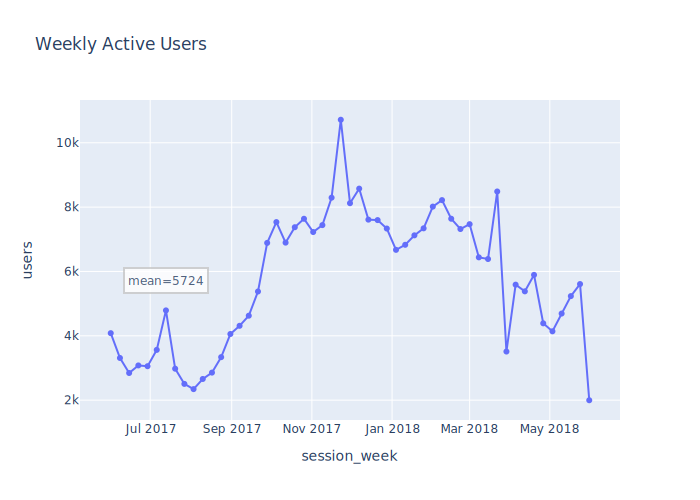

In [17]:
fig = px.scatter(wau, x='session_week', y='users',
                 title='Weekly Active Users')

fig.update_traces(
    mode='lines+markers')

fig.add_annotation(x='2017-07-13', y=int(wau['users'].mean()),
        text=f"mean={int(wau['users'].mean())}",
        align="center",
        showarrow=False,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8)

fig.show()

**MAU**

In [18]:
mau = (
    visits
        .groupby('session_month', as_index=False)
        .agg({'uid': 'nunique'})
        .rename(columns={'uid':'users'})
)

mau

,session_month,users
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


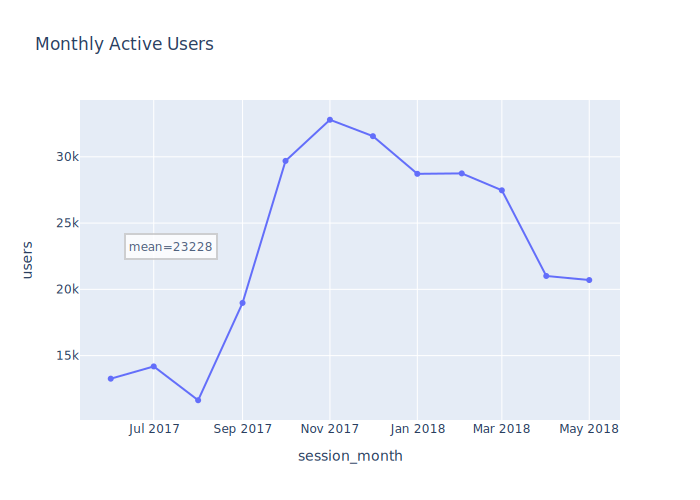

In [19]:
fig = px.scatter(mau, x='session_month', y='users',
                 title='Monthly Active Users')

fig.update_traces(
    mode='lines+markers')

fig.add_annotation(x='2017-07-13', y=int(mau['users'].mean()),
        text=f"mean={int(mau['users'].mean())}",
        align="center",
        showarrow=False,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
        )

fig.show()

У всех графиков есть общая тенденция. Для наглядности можно разделить любой график (DAU,WAU,MAU) на 3 части: в 1 части у нас мало пользователей, далее во второй части число пользователей сильно возрастает, и затем чуть уменьшается и сохраняется примерно в таком положении. Это просто объяснить - у нас было n-число пользователей - мы провели рекламную кампанию, число пользователей резко выросло - часть пользователей стали постоянными, часть отвалилась. В итоге получили прирост пользователей относительно дорекламных значений.

Для полной картины рассчитаем метрику Sticky factor

**Sticky Factor** (липкий фактор) - показатель, благодаря которому можно оценить регулярность использования нашего сайта/приложения.

Допустим, к нам за день на сайт зашло 1000 уникальных пользователей (DAU = 1000). Если допустить, что за весь месяц к нам будут заходить только разные пользователи, то MAU будет равен 30000. Тогда sticky factor будет равен 3%. Если считать понедельный sticky factor, то будет 1000/7000 = 14,3%.

Это означает, что пользователи не задерживаются на нашем сайте - заходят 1 раз и больше не возвращаются. Так и у нас sticky factor за неделю равняется 15,88%, за месяц - 3.91%. Это, несомненно, плохо.

In [20]:
sticky_wau = dau.mean() / wau.mean() * 100
sticky_mau = dau.mean() / mau.mean() * 100

print('Sticky factor of Week:', round(float(sticky_wau), 2))
print('Sticky factor of Month:', round(float(sticky_mau), 2))

Sticky factor of Week: 15.86
Sticky factor of Month: 3.91


#### Определим, сколько раз за день пользователи в среднем заходят на сайт

In [21]:
sessions_per_user = (
    visits
        .groupby('session_date')
        .agg({'device':'count',
              'uid':'nunique'})
        .rename(columns={'device':'n_sessions',
                         'uid':'n_users'})
)

sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

sessions_per_user.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [22]:
print('За день пользователи заходят на сайт в среднем {} раз'.format(int(sessions_per_user['sessions_per_user'].mean())))

За день пользователи заходят на сайт в среднем 1 раз


Изменение данной метрики во времени

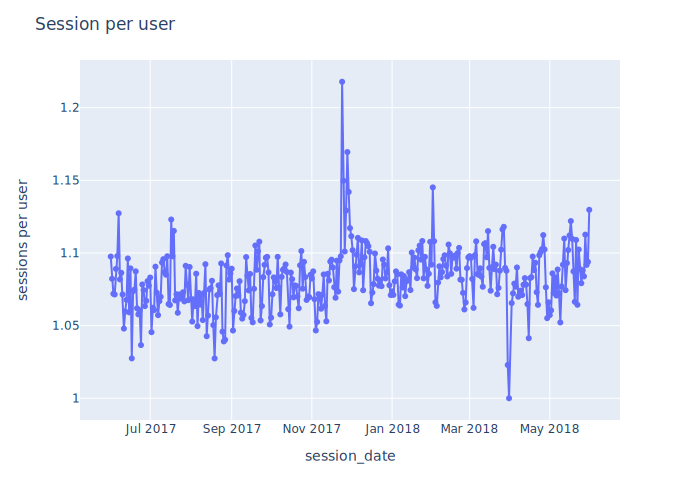

In [23]:
fig = px.scatter(sessions_per_user,
                 x=sessions_per_user.index,
                 y='sessions_per_user')

fig.update_traces(
    mode='lines+markers'
)

fig.update_layout(
    title='Session per user',
    yaxis_title='sessions per user'
)
fig.show()

По графику видно, что в среднем количество сессий не сильно зависит от даты, варьируется в одном и том же диапозоне (1-1.2). Также присутствуют отчетливые выбросы (24 ноября, 1 февраля, 31 марта)

#### Исследуем, сколько времени пользователи проводят на сайте

Для этой задачи мы рассчитаем метрику **ASL**, которая показывает, сколько в среднем длится сессия пользователя

In [24]:
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds

pd.DataFrame(visits['session_duration_sec'].describe()) 

,session_duration_sec
count,359400.000000
mean,643.506489
std,1016.334786
min,0.000000
25%,120.000000
50%,300.000000
75%,840.000000
max,84480.000000


Посмотрим на распределение

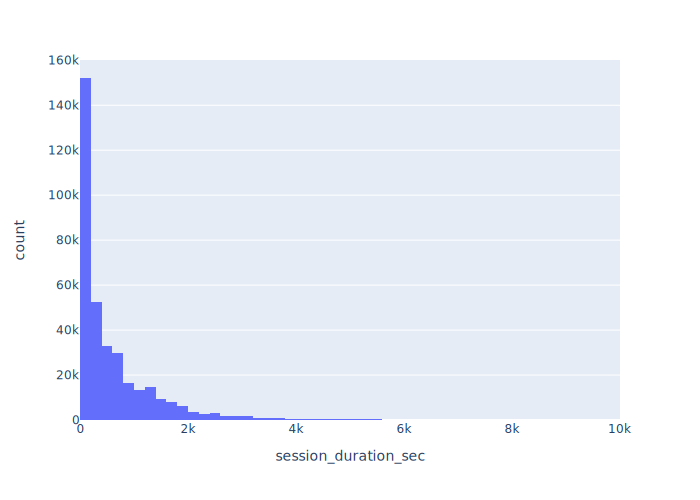

In [25]:
fig = px.histogram(visits, x='session_duration_sec',
                   nbins=500, range_x=(0, 10000))
fig.show()

Очень много "нулевых" сессий. Это объясняется тем, что мы считаем ASL в секундах, а в нашем датасете секунды не считаются. То есть если пользователь пробыл на нашем сайте меньше минуты, то его ASL будет равен 0. Выходит наше распределение не соответствует нормальному, поэтому мы не можем брать в расчет среднее арифметическое. В качестве среднего показателя ASL возьмем моду и медиану

In [26]:
print('ASL mode: {} sec'.format(int(visits['session_duration_sec'].mode())))
print('ASL median: {} sec'.format(int(visits['session_duration_sec'].median())))

ASL mode: 60 sec
ASL median: 300 sec


* Минуты пользователю не хватит, чтобы оформить покупку, вероятно, эти клиенты заходили по ошибке, либо уже с пониманием, чего они хотят, и лишь уточняли время/место.
* Медиана у нас 5 минут, этого вполне хватит на просмотр мероприятий и покупку билета

#### Рассчитаем Retention Rate, применяя когортный анализ.

 Для начала нам нужно вычислить дату, когда пользователь впервые зашел на наш сайт

In [27]:
first_visit = (
    visits
        .groupby('uid', as_index=False)
        .agg({'start_ts':'min'})
        .rename(columns={'start_ts':'first_session_start_ts'})
)

first_visit

,uid,first_session_start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


Мерджим с таблицей визитов

In [28]:
visits = pd.merge(first_visit, visits, on='uid')

visits.head()

,uid,first_session_start_ts,device,end_ts,source_id,start_ts,session_month,session_week,session_date,session_duration_sec
0,11863502262781,2018-03-01 17:27:00,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018-03-01,2018-03-01,2018-03-01,360
1,49537067089222,2018-02-06 15:55:00,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018-02-01,2018-02-01,2018-02-06,120
2,297729379853735,2017-06-07 18:47:00,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017-06-01,2017-06-01,2017-06-07,60
3,313578113262317,2017-09-18 22:49:00,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,2018-03-01,2018-03-08,2018-03-11,360
4,313578113262317,2017-09-18 22:49:00,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-01,2017-09-14,2017-09-18,1080


Формировать нашу когорту будем по данным за месяц

Добавим столбцы с датой и месяцем первого визита

In [29]:
visits['first_session_date'] = visits['first_session_start_ts'].dt.date
visits['first_session_month'] = visits['first_session_start_ts'].astype('datetime64[M]')

In [30]:
visits['cohort_lifetime'] = ((
    visits['session_month'] - visits['first_session_month']
) / np.timedelta64(1, 'M')).round().astype('int')

cohorts = (
    visits
        .groupby(['first_session_month', 'cohort_lifetime'], as_index=False)
        .agg({'uid':'nunique'})
)

initial_users_count = (
    cohorts
        .query('cohort_lifetime == 0')[['first_session_month', 'uid']]
        .rename(columns={'uid':'cohort_users'})
)

cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_session_month'] = cohorts['first_session_month'].dt.date 

retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


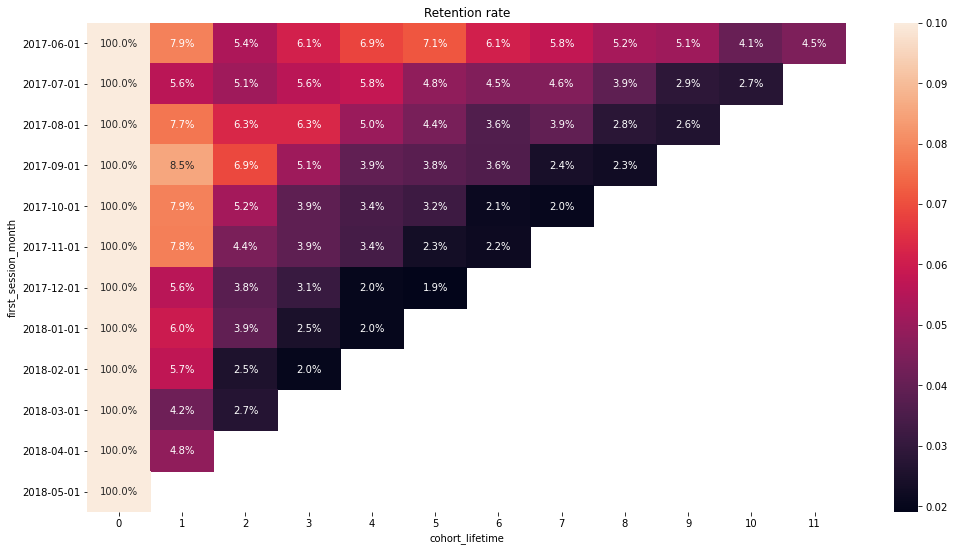

In [31]:
plt.subplots(figsize=(17,9))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', vmax=0.1)
plt.title('Retention rate')

plt.show()

#### Вывод

1. Судя по DAU/WAU/MAU, активных пользователей у нас много - это хорошо.
2. Однако, пользователи заходят на сайт 1 раз в день - не сказать, что это плохо, но и не хорошо. Я думаю, хорошим вариантом будет пересмотреть систему push-уведомлений.
3. К тому же сессия в среднем длится 1 минуту - это определенно плохо. За 1 минуту просмотреть концерты/кино в городе пользователь не успеет, что уж говорить о покупке билета через приложение. Нужно увеличивать данный показатель - возможно, пользователю непонятен дизайн сайта, тогда надо двигаться в сторону интуитивно-понятного интерфейса
4. С Retention Rate у нас всё плохо:
      - Во-первых, в первый же месяц любая когорта теряет более 90% пользователей. Пользователи уже за месяц перестают пользоваться нашим сайтом.
      - Во-вторых, RR в первую неделю убывает по когортам с течением времени - в когороте июня у нас 7,9% RR, когда как в когорте апреля следующего года уже 4,8%.

### Метрики электронной коммерции

#### Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

Добавим день и месяц заказа, чтобы посчитать суммарную выручку за эти периоды

In [32]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

Найдем время первой покупки каждого покупателя

In [33]:
first_order = (
    orders
        .groupby('uid', as_index=False)
        .agg({'buy_ts':'min'})
        .rename(columns={'buy_ts':'first_order_ts'})
)

first_order

,uid,first_order_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [34]:
first_order['first_order_date'] = first_order['first_order_ts'].dt.date
first_order['first_order_month'] = first_order['first_order_ts'].astype('datetime64[M]')

first_order

,uid,first_order_ts,first_order_date,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01
...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-11-24,2017-11-01
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22,2017-09-01
36520,18445601152732270159,2018-03-26 22:54:00,2018-03-26,2018-03-01
36521,18446156210226471712,2018-02-18 19:34:00,2018-02-18,2018-02-01


Объединяем данные о первых покупках с данными о первых сессиях

In [35]:
buyers = pd.merge(first_visit, first_order, on='uid')
buyers

,uid,first_session_start_ts,first_order_ts,first_order_date,first_order_month
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,2018-01-03,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-01
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,2017-10-11,2017-10-01
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,2018-01-28,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-01
...,...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,2017-11-24,2017-11-01
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,2017-09-22,2017-09-01
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,2018-03-26,2018-03-01
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,2018-02-18,2018-02-01


Считаем, сколько дней проходит с момента первого захода на сайт до первой покупки

In [36]:
buyers['days_to_first_purchase'] = ((
    buyers['first_order_ts'] - buyers['first_session_start_ts']
) / np.timedelta64(1, 'D')).astype('int')

buyers

,uid,first_session_start_ts,first_order_ts,first_order_date,first_order_month,days_to_first_purchase
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,2018-01-03,2018-01-01,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06-03,2017-06-01,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,2017-10-11,2017-10-01,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,2018-01-28,2018-01-01,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,2017-11-24,2017-11-01,0
...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,2017-11-24,2017-11-01,95
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,2017-09-22,2017-09-01,0
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,2018-03-26,2018-03-01,231
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,2018-02-18,2018-02-01,103


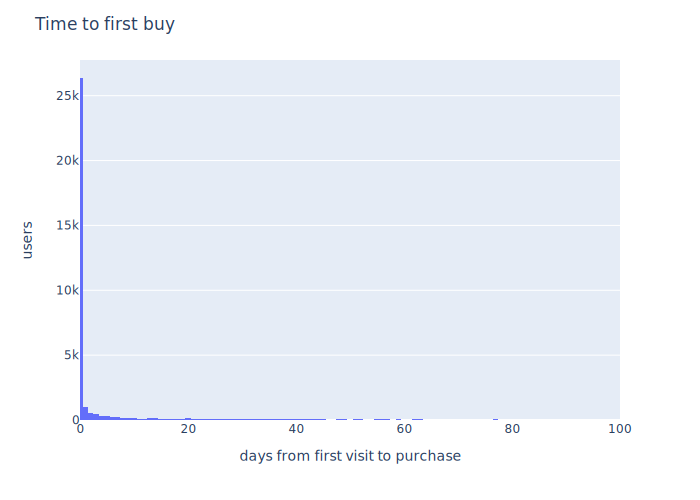

In [37]:
fig = px.histogram(buyers, x='days_to_first_purchase',
                   nbins=400, range_x=(0, 100))
fig.update_layout(
    title='Time to first buy',
    xaxis_title='days from first visit to purchase',
    yaxis_title='users'
)
fig.show()

Видим, что подавляющее большинство пользователей (почти 30000) совершают первую покупку в первый же день посещения сайта 

In [38]:
print('Time to first purchase (mode):', buyers['days_to_first_purchase'].mode()[0])
pd.DataFrame(buyers['days_to_first_purchase'].describe())

Time to first purchase (mode): 0


,days_to_first_purchase
count,36523.000000
mean,16.729869
std,46.959088
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,363.000000


Чаще всего пользователи делали покупку в первый день посещения сайта

#### С помощью когоротного анализа рассчитаем среднее количество покупок на одного покупателя за 6 месяцев.

Найдем число покупателей в каждой когорте

In [39]:
cohort_sizes = (
    buyers
        .groupby('first_order_month', as_index=False)
        .agg({'uid':'nunique'})
        .rename(columns={'uid':'n_buyers'})
)

cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [40]:
cohorts = (
    pd.merge(orders, buyers, on='uid')
        .groupby(['first_order_month', 'order_month'], as_index=False)
        .agg({'revenue':'count'})
        .rename(columns={'revenue':'n_orders'})
)

cohorts.head()

,first_order_month,order_month,n_orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


Считаем возраст каждой когорты

In [41]:
cohorts['age_month'] = ((
    cohorts['order_month'] - cohorts['first_order_month']
) / np.timedelta64(1, 'M')).round()

Добавляем количество покупателей в каждой когорте и считаем количество заказов на каждого покупателя

In [42]:
cohorts_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
cohorts_report['orders_per_buyers'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']
cohorts_report['age_month'] = cohorts_report['age_month'].astype('int')

cohorts_report

,first_order_month,n_buyers,order_month,n_orders,age_month,orders_per_buyers
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2,0.049816
75,2018-04-01,2276,2018-04-01,2495,0,1.096221
76,2018-04-01,2276,2018-05-01,195,1,0.085677
77,2018-05-01,2988,2018-05-01,3249,0,1.087349


In [43]:
cohorts_age = cohorts_report.pivot_table(
    index='first_order_month',
    columns='age_month',
    values='orders_per_buyers',
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


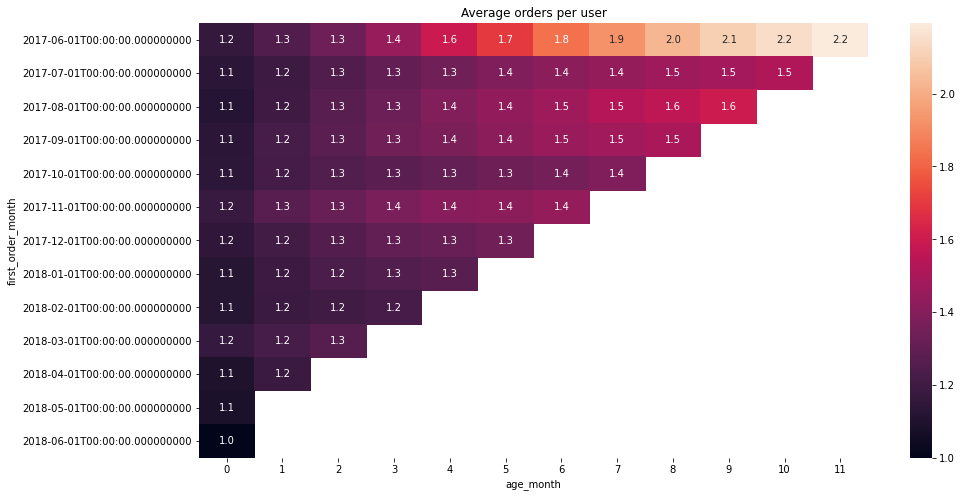

In [44]:
plt.subplots(figsize=(15,8))
sns.heatmap(cohorts_age, annot=True, fmt='.1f')
plt.title('Average orders per user')

plt.show()

In [45]:
cohorts_age.cumsum(axis=1).mean(axis=0)[5]

7.820097325169913

В среднем 1 пользователь совершает 8 покупок за 6 месяцев

#### Рассчитаем средний чек, применив группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты.

Считать средний чек будем за месяц

In [46]:
avg_check = orders.groupby('order_month').agg({'uid':'count', 'revenue':'sum'})
avg_check['avg_check'] = avg_check['revenue'] / avg_check['uid']

avg_check

,uid,revenue,avg_check
order_month,,,
2017-06-01,2354,9557.49,4.060106
2017-07-01,2363,12539.47,5.306589
2017-08-01,1807,8758.78,4.847139
2017-09-01,3387,18345.51,5.416448
2017-10-01,5679,27987.70,4.928280
2017-11-01,5659,27069.93,4.783518
2017-12-01,6218,36388.60,5.852139
2018-01-01,4721,19417.13,4.112927
2018-02-01,5281,25560.54,4.840095


In [47]:
pd.DataFrame(avg_check['avg_check'].describe())

,avg_check
count,13.000000
mean,4.838700
std,0.656336
min,3.420000
25%,4.771279
50%,4.847139
75%,5.306589
max,5.852139


Средний чек за всё время - почти 5 у.е.

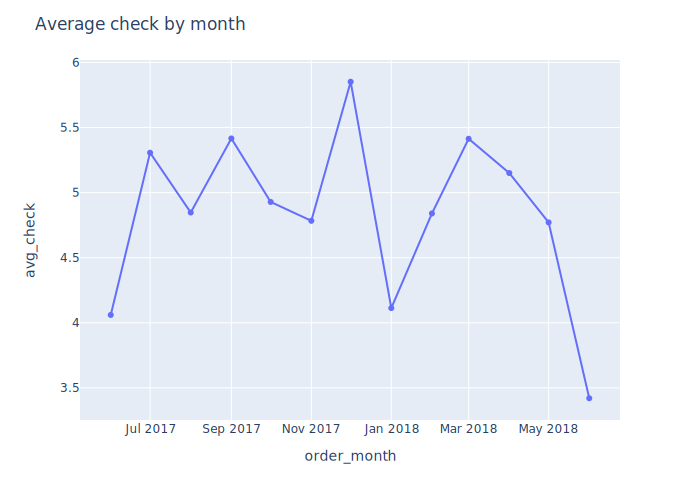

In [48]:
fig = px.scatter(avg_check,
                 x=avg_check.index, y='avg_check')

fig.update_traces(
    mode='lines+markers'
)
fig.update_layout(
    title='Average check by month',
    yaxis_title='avg_check'
)

fig.show()

Максимальное значение среднего чека у нас в декабре - это можно объяснить новогодними подарками. В январе средний чек резко падает - это логично, как минимум, люди начинают экономить после новогодних праздников, а то может и вообще денег не осталось

#### Выясним, как меняется LTV на покупателя по когортам. Рассчитаем средний LTV по когортам за 6 месяцев: в расчёт включаем когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

Когорту будем формировать по месяцам

In [49]:
cohorts = (
    pd.merge(orders, buyers, on='uid')
        .groupby(['first_order_month', 'order_month'], as_index=False)
        .agg({'revenue':'sum'})
)

cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [50]:
cohorts['age_month'] = (((
    cohorts['order_month'] - cohorts['first_order_month']
) / np.timedelta64(1, 'M')).round()).astype('int')

Добавляем количество покупателей в каждой когорте и считаем выручку на каждого пользователя

In [51]:
cohorts_report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
cohorts_report['ltv'] = cohorts_report['revenue'] / cohorts_report['n_buyers']

cohorts_report.head()

,first_order_month,n_buyers,order_month,revenue,age_month,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [52]:
cohorts_age = cohorts_report.pivot_table(
    index='first_order_month',
    columns='age_month',
    values='ltv',
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


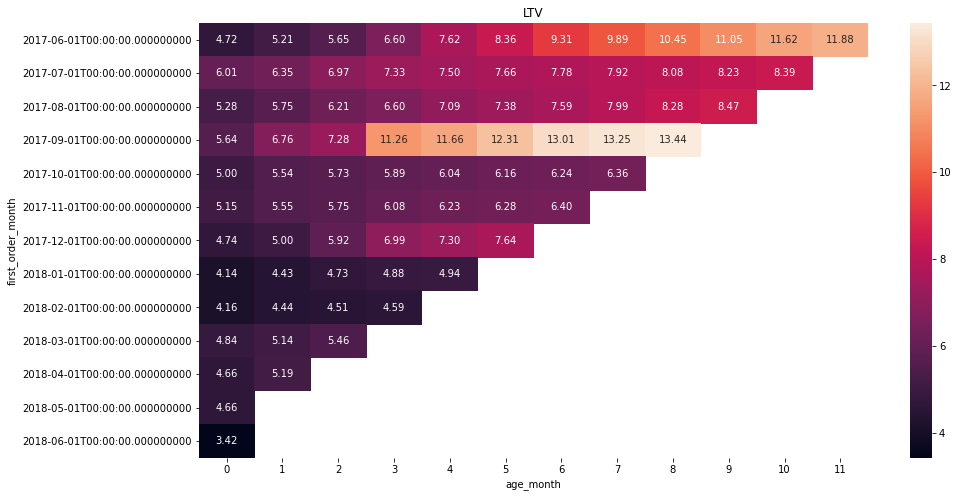

In [53]:
plt.subplots(figsize=(15,8))
sns.heatmap(cohorts_age, annot=True, fmt='.2f')
plt.title('LTV')

plt.show()

Средний LTV за 6 месяцев по когортам, прожившим не менее 6 месяцев, 

In [54]:
cohorts_age.query('first_order_month <= "2017-12-01"').cumsum(axis=1).mean(axis=0)[5]

40.028463579000075

#### Вывод

1. Более 70% пользователей совершают покупку в первый же день посещения сайта. То есть пользователи впервые заходят на сайт уже с целью покупки билета на что-то. Они заранее решили куда пойдут, а это не есть хорошо, я думаю. Реклама каких-то мест на нашем сервисе им не нужна, они не используют сайт в качестве помощника для выбора мест отдыха.
2. В среднем за 6 месяцев 1 покупатель совершает 8 покупок.
3. Средний чек у нас почти 5 у.е. Пока не хвататет информации, чтобы сказать, хорошо это или плохо
4. Средний LTV за 6 месяцев - 40. Тоже пока нельза дать оценку, нужно рассчитать CAC

### Маркетинговые метрики

#### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам.


In [55]:
costs_total = costs['costs'].sum()
print('Costs total:', costs_total)

Costs total: 329131.62


In [56]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

costs

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


Посмотрим на расходы по месяцам

In [57]:
costs_by_month = (
    costs
        .groupby('costs_month', as_index=False)
        .agg({'costs':'sum'})
)

costs_by_month

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


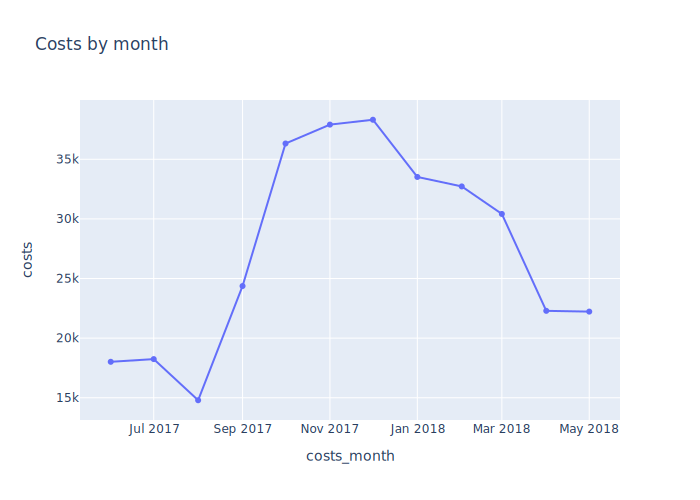

In [58]:
fig = px.scatter(costs_by_month, x='costs_month', y='costs',
                 title='Costs by month')

fig.update_traces(
    mode='lines+markers'
)

fig.show()

Посчитаем расходы на маркетинг в разрезе источников по месяцам

In [59]:
costs_by_source = costs.pivot_table(
    index='costs_month',
    columns='source_id',
    values='costs',
    aggfunc='sum'
)

costs_by_source

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


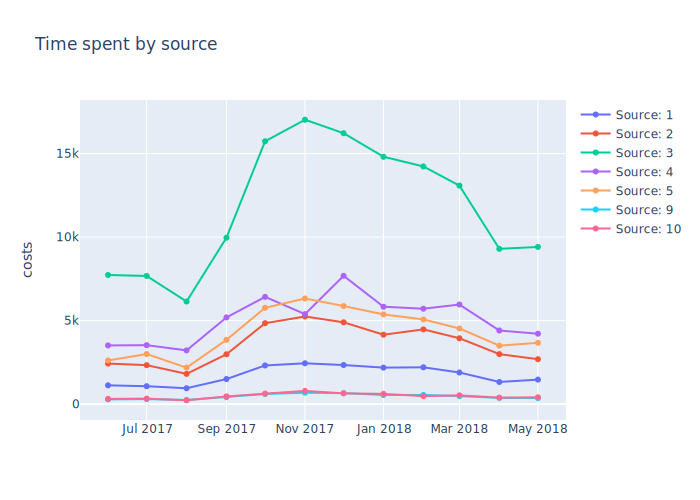

In [60]:
costs_by_source.columns = costs_by_source.columns.astype('str')

fig = go.Figure()

for col in costs_by_source.columns.astype('str'):
    fig.add_scatter(x=costs_by_source.index,
                    y=costs_by_source[col], name=f'Source: {col}')
    
fig.update_layout(
    title='Time spent by source',
    yaxis_title='costs'
)    

fig.show()

Посмотрим общие расходы на каждый источник

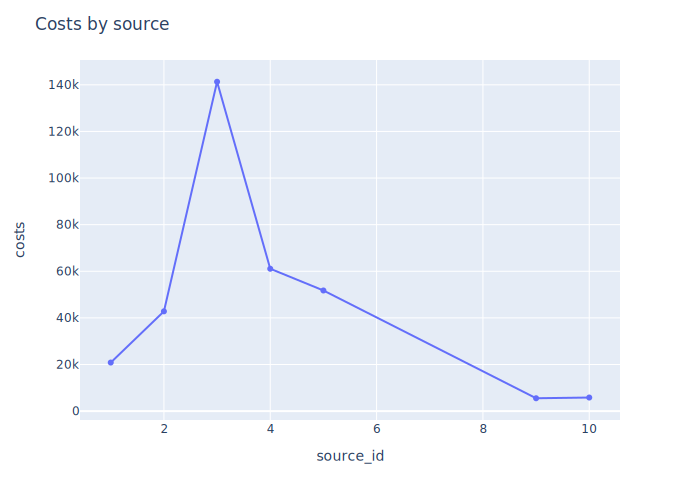

In [61]:
fig = px.scatter((
    costs
        .groupby('source_id', as_index=False)
        .agg({'costs':'sum'})
),  x='source_id', y='costs')

fig.update_traces(
    mode='lines+markers'
)

fig.update_layout(
    title='Costs by source'
)
fig.show()

Львиная доля маркетингового бюджета вложена в 3 источник (почти 50%). 6-8 источники, видимо, уже убрали ввиду неэффективности. 9-10 источники аутсайдеры по бюджету - всего по 6000 у.е.

Можем посмотреть окупается ли наш проект

In [62]:
print('Total revenue:', round(orders['revenue'].sum(), 2))
print('Total costs:', round(costs['costs'].sum(), 2))
print('Income:', round(orders['revenue'].sum()-costs['costs'].sum(), 2))

Total revenue: 252057.2
Total costs: 329131.62
Income: -77074.42


Пока что в минусе на 77000 у.е.



Можем посмотреть на изменение прибыли во времени

In [63]:
income = pd.merge((
    orders
        .groupby('order_month', as_index=False)
        .agg({'revenue':'sum'})
        .rename(columns={'order_month':'month'})
), (
    costs
        .groupby('costs_month', as_index=False)
        .agg({'costs':'sum'})
        .rename(columns={'costs_month':'month'})

), on='month', how='left').fillna(0)

income['income'] = income['revenue'] - income['costs']
income

,month,revenue,costs,income
0,2017-06-01,9557.49,18015.00,-8457.51
1,2017-07-01,12539.47,18240.59,-5701.12
2,2017-08-01,8758.78,14790.54,-6031.76
3,2017-09-01,18345.51,24368.91,-6023.40
4,2017-10-01,27987.70,36322.88,-8335.18
5,2017-11-01,27069.93,37907.88,-10837.95
6,2017-12-01,36388.60,38315.35,-1926.75
7,2018-01-01,19417.13,33518.52,-14101.39
8,2018-02-01,25560.54,32723.03,-7162.49
9,2018-03-01,28834.59,30415.27,-1580.68


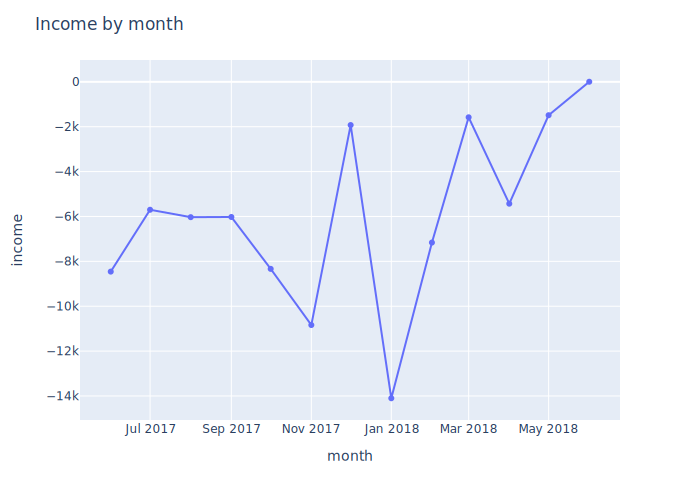

In [64]:
fig = px.scatter(income, x='month', y='income')

fig.update_traces(
    mode='lines+markers'
)

fig.update_layout(
    title='Income by month'
)
fig.show()

В декабре почти вышли в ноль, опять же сезон праздников и подарков. Как следствие, в январе потеряли больше всего денег. Но наблюдается положительная тенденция, с января график показывает растущий тренд, и, возможно, летом 2018 компания уже выйдет в 0

#### Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

CAC для всего проекта

In [65]:
cac_total = costs_total / orders['uid'].nunique()
print('CAC total:', round(cac_total, 2))

CAC total: 9.01


In [66]:
cac_by_month = pd.merge(costs.groupby('costs_month').agg({'costs':'sum'}),
                        buyers.groupby('first_order_month').agg({'uid':'nunique'}),
                        left_index=True, right_index=True).reset_index()

cac_by_month.rename(columns={'index':'month'}, inplace=True)
cac_by_month['CAC'] = cac_by_month['costs'] / cac_by_month['uid']

cac_by_month

,month,costs,uid,CAC
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4081,9.288870
6,2017-12-01,38315.35,4383,8.741809
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3533,8.608907


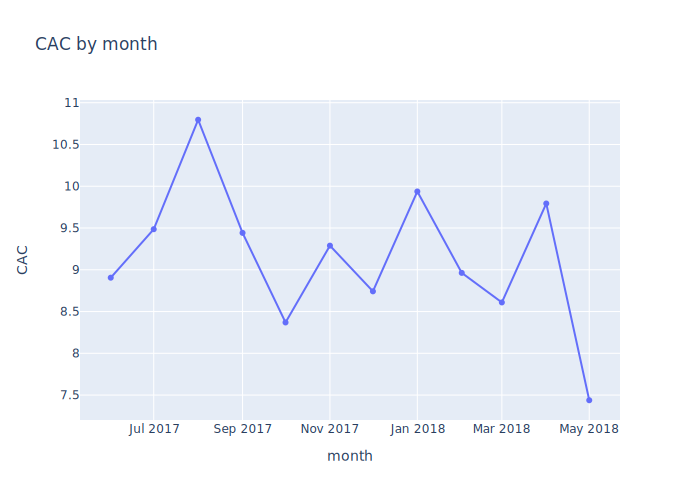

In [67]:
fig = px.scatter(cac_by_month, x='month', y='CAC',
                 title='CAC by month')

fig.update_traces(
    mode='lines+markers'
)

fig.show()

Самых дорогих клиентов мы привлекли в августе 2017 года, а так CAC в среднем колеблется в +- одном диапазоне

CAC для каждого источника

Для начала нужно найти главный источник перехода. Главным будем считать первый источник перехода.

In [68]:
main_source = (
    visits
        .groupby(['uid', 'first_session_start_ts'], as_index=False)
        .agg({'source_id':'min'})
        .drop(columns='first_session_start_ts')
)

main_source

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


In [69]:
orders = pd.merge(orders, main_source, on='uid', how='left')
orders

,buy_ts,revenue,uid,buy_date,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-01,3


In [70]:
cac_source = pd.merge((
    orders
        .groupby('source_id', as_index=False)
        .agg({'uid':'nunique'})
        .rename(columns={'uid':'buyers'})
), (
    costs
        .groupby('source_id', as_index=False)
        .agg({'costs':'sum'})

), on='source_id')

cac_source['cac'] = cac_source['costs'] / cac_source['buyers']
cac_source

,source_id,buyers,costs,cac
0,1,7138,20833.27,2.918642
1,2,5336,42806.04,8.022121
2,3,9619,141321.63,14.691925
3,4,8138,61073.60,7.504743
4,5,4879,51757.10,10.608137
5,9,527,5517.49,10.469620
6,10,885,5822.49,6.579085


В 3 источник инвестируется 50% бюджета, а получаем всего 9600 клиентов, притом, что 4 источник с бюджетом в 2 раза меньше, привлекает 8000.

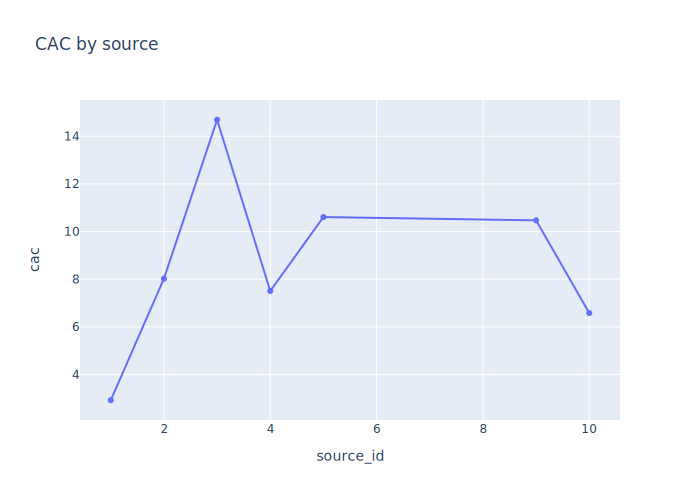

In [71]:
fig = px.scatter(cac_source,
                 x='source_id', y='cac',
                 title='CAC by source')

fig.update_traces(
    mode='lines+markers'
)

fig.show()

Половина бюджета в 3 источнике, а он приносит нам самых дорогих клиентов (14 у.е.). Определенно нужно уменьшать инвестиции в 3 кампанию и перераспределять по другим источникам.

#### Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт.

Добавим дату первого заказа в заказы

In [72]:
orders = pd.merge(orders, first_order[['uid', 'first_order_date', 'first_order_month']], on='uid')
orders

,buy_ts,revenue,uid,buy_date,order_month,source_id,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01,4,2018-05-31,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01,10,2018-05-31,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01,3,2018-05-31,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-01,3,2018-05-31,2018-05-01


Функция вчисления ROMI По источникам

In [73]:
def romi_by_source(source):
   
    # Расчет размера когорт по кол-ву уникальных покупателей по заказам отфильтрованным по источнику
    coghort_size_n_buyers_x = (
        orders.query('source_id == @source')
            .groupby('first_order_month', as_index=False)
            .agg({'uid' : 'nunique'})
            .rename(columns={'uid':'n_buyers'})
    )
    
    # Группировка заказов по месяцу первого заказ, месяцу зказа, суммирование выручки
    cohorts_x = (
        orders.query('source_id == @source')
            .groupby(['first_order_month', 'order_month'], as_index=False)
            .agg({'revenue': 'sum'})
    )
   
    # Объеднине когорт с кол-вом уникальных покупателей и когорт с выручкой
    coghort_report_x = pd.merge(coghort_size_n_buyers_x, cohorts_x, on='first_order_month')
    
    # Выделение столбца с возрастом когорты и расчет LTV
    coghort_report_x['age'] = (
        coghort_report_x['order_month'] - coghort_report_x['first_order_month']
    ) / np.timedelta64(1, 'M')
    coghort_report_x['age'] = coghort_report_x['age'].round().astype('int')
    
    # Расчет LTV
    coghort_report_x['ltv'] = (
        coghort_report_x['revenue'] / coghort_report_x['n_buyers']
    )
    
    # Таблица расходов отфильтрованных по источнику
    costs_by_month_x = costs.query('source_id == @source')[['costs_month', 'costs']]
    
    # Расчет расходов по месяцам
    costs_by_month_x = costs_by_month_x.groupby('costs_month').sum()
    
    # Объединение отчета LTV по когортам и расходов по месяцам
    ltv_cac_report_x = pd.merge(coghort_report_x, costs_by_month_x,
                                left_on='first_order_month', right_on='costs_month')
    
    # Расчет CAC
    ltv_cac_report_x['cac'] = ltv_cac_report_x['costs'] / ltv_cac_report_x['n_buyers']
    
    # Расчет ROMI
    ltv_cac_report_x['romi'] = ltv_cac_report_x['ltv'] / ltv_cac_report_x['cac']
    
    # Формат когорты год-месяц
    ltv_cac_report_x['first_order_month'] = ltv_cac_report_x['first_order_month'].dt.strftime('%Y-%m')
    
    # Построение Pivot по источнику
    romi_pivot_x = ltv_cac_report_x.pivot_table(
        index='first_order_month',
        columns='age',
        values='romi',
        aggfunc='mean').cumsum(axis=1)
    
    plt.figure(figsize=(15,8)),
    sns.heatmap(romi_pivot_x, annot=True, fmt='.2f'),
    plt.title('ROMI' + ' ' + 'источник' + ' ' + str(source)),
    plt.xlabel('ROMI накопительно'),
    plt.ylabel('когорты'),  
    plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

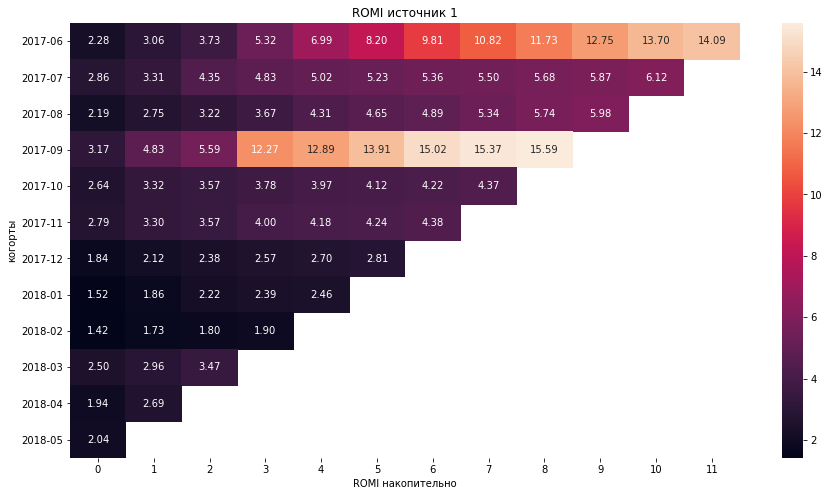

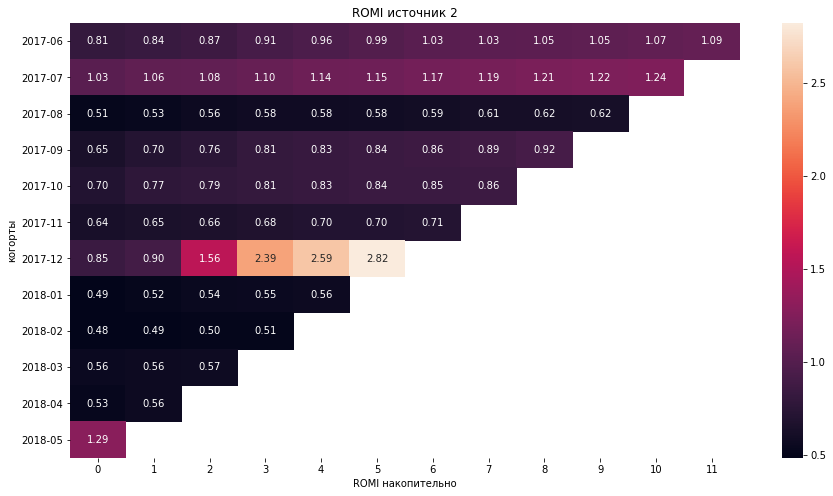

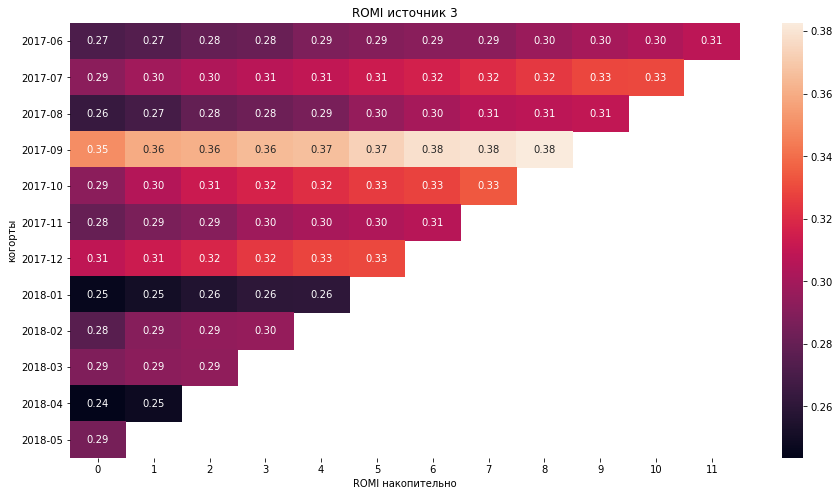

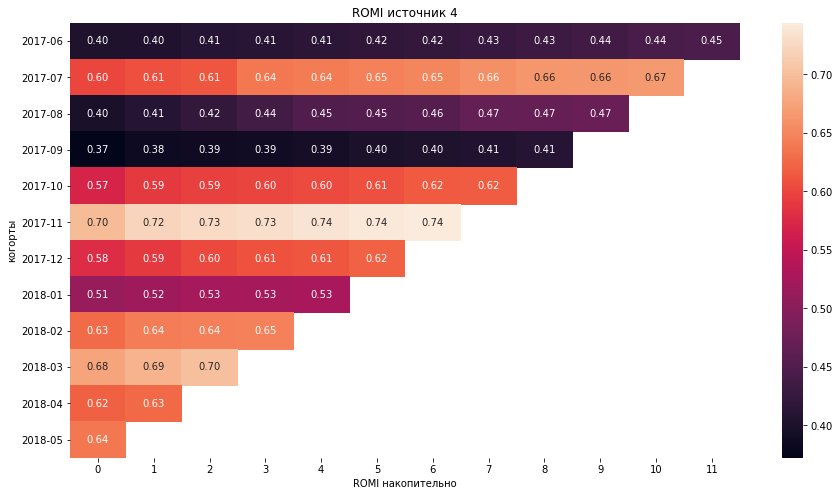

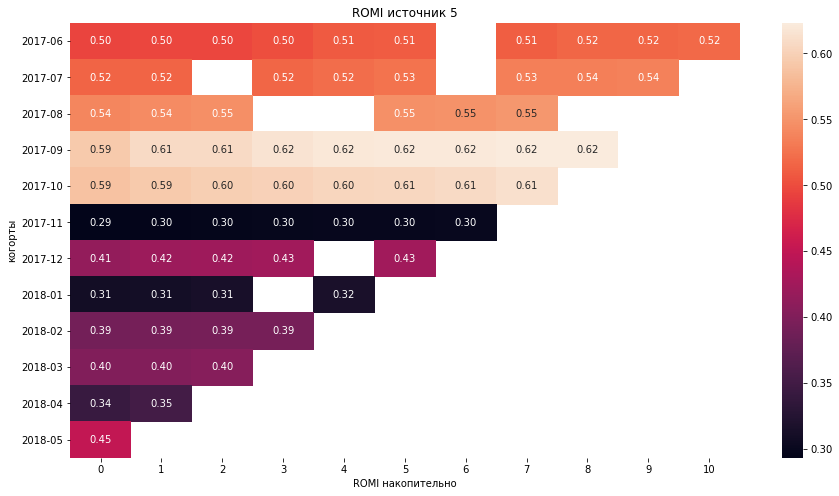

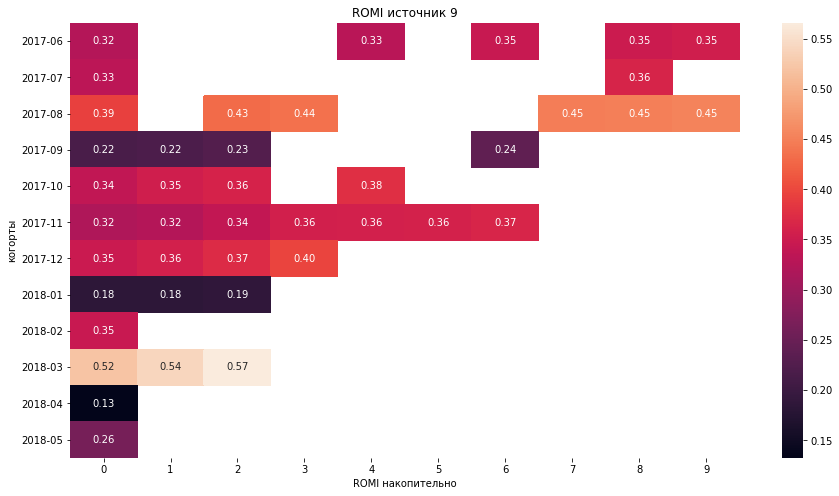

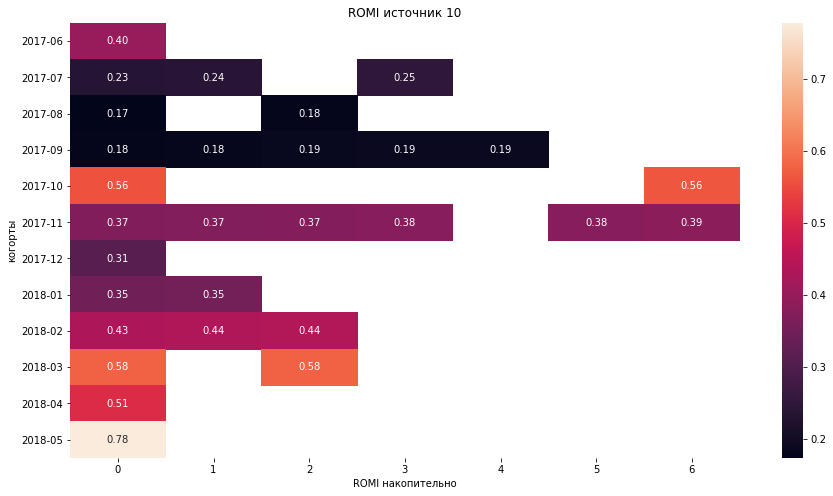

In [74]:
for source in tqdm(costs['source_id'].unique()):
    romi_by_source(source)

#### Вывод

1. Всего на маркетинг было потрачено 329132 у.е. Из них почти половина вложена в 3 источник (141322 у.е.). 
2. 3 источник трафика привлекает мало клиентов, учитывая его бюджет. К тому же, это самые дорогие клиенты - 14 у.е. 
3. В среднем мы возвращаем наши инвестиции за 12 месяцев.

# Общий вывод и рекомендации

1. Маркетологам стоит делать упор на источники трафика 1, 2 и 4. Потому что у этих источников много привлеченных клиентов (7138, 5336 и 8138), отличные значения метрики LTV (14, 8 и 4.5) и минимальные значения CAC (2.91, 8 и 7.5). У 1 источнка так же лучшие показатели метрики ROMI. Фаворитом я бы сделал именно 1 источник, у него самые лучшие показатели. 
2. * Судя по продуктовым метрикам у нас много пользователей, это отлично. Однако, они заходят на сайт лишь 1 раз в день, и к тому же сессия у них длится в районе 1 минуты. Это видно и благодаря метрике sticky factor. С этим надо работать и улучшать. Так же у нас плохой Retention Rate - в первый же месяц мы теряем 90% пользователей, и затем эти количество только уменьшается. Нужно придумать, чем удерживать клиентов. 
    
 * Метрики электронной коммерции. 40% пользователей делают заказ в день первого посещения сайта. Сайтом пользуются не как средством поиска мероприятий и мест досуга, а в качестве платежного сервиса. В среднем за 6 месяцев 1 покупатель совершает 8 покупок. Средний чек 5 у.е. LTV - 40. 
    
 * Маркетинговые метрики. Всего мы вложили в рекламу 330000 у.е. Как уже было сказано, почти половина бюджета ушла на 3 источник, что плохо сказалось на нас. CAC по всему проекту - 9 у.е. Маркетологам стоит значительно уменьшить бюджет на 3 источник - он приносит нам чуть больше клиентов, чем 1 источник (9600 против 7138), а CAC у 1 источника в 7 раз меньше 3. Окупаются у нас пока только 1 и 2 источники.
3. Самые перспективные для компании когорты, судя по показателям LTV  - июньская и сентябрьская когорты  2017 года.